In [1]:
#pip install numpy==1.23.5
#pip install pandas scipy matplotlib statsmodels
#pip install torch
#pip install pytorch_forecasting
#pip install pyarrow
#pip install tensorflow
#pip install tensorboard

In [2]:
# pip install seaborn

In [3]:
import os
import random
import pickle

# Data and plotting libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# PyTorch and PyTorch Lightning
import torch
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.tuner import Tuner

# PyTorch Forecasting
import pytorch_forecasting
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss, CrossEntropy

# Scikit-learn metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)

In [4]:
import numpy as np
print(np.__version__)

1.23.5


In [7]:
# Set Seed for all packages
def set_seed(seed=42):
    """Set seeds to make the experiment more reproducible."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [8]:
def evaluate_tft_predictions(flat_labels, transformed_predictions, directory, model_name, threshold=None, beta=2):
    sns.set()  # For better plot styling

    # Ensure that the inputs are numpy arrays
    flat_labels = np.array(flat_labels)
    transformed_predictions = np.array(transformed_predictions)

    # Use the max predicted probability across timesteps for each sample
    max_predictions = np.max(transformed_predictions, axis=1)

    # Compute mortality predictions based on the threshold (applied to the max probability per sample)
    if threshold is not None:
        # If a threshold is provided, use it to compute mortality predictions
        mortality_predictions = (max_predictions > threshold).astype(int)
    else:
        # If no threshold is provided, compute the precision-recall curve and the best threshold based on F-beta score
        precision_vals, recall_vals, thresholds = precision_recall_curve(flat_labels, max_predictions)

        # Calculate F-beta scores for each possible threshold
        f_beta_scores = (1 + beta**2) * (precision_vals * recall_vals) / ((beta**2 * precision_vals) + recall_vals)
        f_beta_scores = np.nan_to_num(f_beta_scores)  # Handle 

        # Find the threshold that maximizes the F-beta score
        optimal_idx = np.argmax(f_beta_scores)
        best_threshold = thresholds[optimal_idx]
        print(f"Best Threshold based on F{beta} score: {best_threshold:.4f}")

        # Use the best threshold to compute mortality predictions
        mortality_predictions = (max_predictions > best_threshold).astype(int)
        threshold = best_threshold  # Set the threshold to the best threshold for reporting later

    # Compute Accuracy
    accuracy = accuracy_score(flat_labels, mortality_predictions)
    print(f"Accuracy: {accuracy:.4f}")

    # Compute Precision
    precision = precision_score(flat_labels, mortality_predictions, zero_division=0)
    print(f"Precision: {precision:.4f}")

    # Compute Recall
    recall = recall_score(flat_labels, mortality_predictions)
    print(f"Recall: {recall:.4f}")

    # Compute F1 Score
    f1 = f1_score(flat_labels, mortality_predictions)
    print(f"F1 Score: {f1:.4f}")

    # Compute AUROC (Area Under the Receiver Operating Characteristic Curve)
    roc_auc = roc_auc_score(flat_labels, max_predictions)
    print(f"AUROC: {roc_auc:.4f}")

    # Compute AUPRC (Area Under the Precision-Recall Curve)
    auprc = average_precision_score(flat_labels, max_predictions)
    print(f"AUPRC: {auprc:.4f}")

    # Ensure the directory exists
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the confusion matrix
    cm = confusion_matrix(flat_labels, mortality_predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{directory}/{model_name}_confusion_matrix.png')
    plt.close()  # Close the plot to avoid display

    # Save performance metrics to a text file
    metrics_filepath = f'{directory}/{model_name}_metrics.txt'
    with open(metrics_filepath, 'w') as f:
        f.write(f"{model_name} Model Performance on Test Set:\n")
        f.write(f"Threshold used: {threshold:.4f}\n")
        f.write(f"Accuracy: {accuracy:.4f}\n")
        f.write(f"Precision: {precision:.4f}\n")
        f.write(f"Recall: {recall:.4f}\n")
        f.write(f"F1 Score: {f1:.4f}\n")
        f.write(f"AUROC: {roc_auc:.4f}\n")
        f.write(f"AUPRC: {auprc:.4f}\n")

    print(f"Performance metrics saved to: {metrics_filepath}")


# Load Data

In [9]:
# Define the percentage to load
percentage = '1%'  # Change this to '5%', '10%', etc., as needed

# Base directory for the data subsets
base_dir = f'./data/subsets/{percentage}_subsets/'

# Load Labels
labels = pd.read_csv(f'{base_dir}labels.csv')
stay_ids = labels['stay_id'].unique()

# Load static features
icd_features = pd.read_pickle(f'{base_dir}icd_code_features.pkl')

# Load summarized dynamic features
dynamic_data_df = pd.read_pickle(f'{base_dir}dynamic_data_df.pkl')

# Load demographic features
demographic_features = pd.read_pickle(f'{base_dir}demographic_features.pkl')

# Print information to confirm the files are loaded
print(f"Files for {percentage} subset loaded successfully.")
print(f"Number of stays: {len(stay_ids)}")
print(f"ICD Features shape: {icd_features.shape}")
print(f"Dynamic Features shape: {dynamic_data_df.shape}")
print(f"Demographic Features shape: {demographic_features.shape}")

Files for 1% subset loaded successfully.
Number of stays: 475
ICD Features shape: (475, 1458)
Dynamic Features shape: (5700, 835)
Demographic Features shape: (475, 4)


In [10]:
# Concatenating the DataFrames along the columns (axis=1)
all_static_features = pd.concat([icd_features, demographic_features], axis=1)

# Flatten the multi-level columns into a single level
flattened_columns = ['_'.join(map(str, col)) for col in dynamic_data_df.columns]

# Update the DataFrame with flattened columns
dynamic_data_df.columns = flattened_columns

# Rename 'stay_id_' column to 'stay_id'
dynamic_data_df = dynamic_data_df.rename(columns={'stay_id_': 'stay_id'})

dynamic_data_df.index.names = ['time_idx']
dynamic_data_df.reset_index(inplace=True)

# Define dynamci columns
dynamic_columns = dynamic_data_df.columns.difference(['time_idx', 'stay_id'])

demographic_features.index.names = ['stay_id']

full_data_df = pd.merge(dynamic_data_df, demographic_features, left_on='stay_id', right_index=True, how='left')

# Merge the resulting data with labels (assuming labels has stay_id as a regular column)
full_data_df = pd.merge(full_data_df, labels, on='stay_id', how='left')

In [11]:
# Keeping the first 10 and the last 10 columns of the DataFrame
#first_10_columns = full_data_df.iloc[:, :10]  # First 10 columns
#last_10_columns = full_data_df.iloc[:, -10:]  # Last 10 columns

# Concatenating the first 10 and last 10 columns
#full_data_df = pd.concat([first_10_columns, last_10_columns], axis=1)

In [12]:
# SUbset for faster testing
#full_data_df = full_data_df[:1000]

# Train Validation Test Split

In [13]:
from sklearn.model_selection import train_test_split

train_stays, temp_stays = train_test_split(labels, test_size=0.3, random_state=42, stratify=labels['label'])

# Now split temp into test and validation sets equally
test_stays, val_stays = train_test_split(temp_stays, test_size=0.5, random_state=42, stratify=temp_stays['label'])

In [14]:
print(len(train_stays))
print(len(val_stays))
print(len(test_stays))

332
72
71


In [15]:
# Define Slices of Full Data Based on the split
train_data = full_data_df[full_data_df['stay_id'].isin(train_stays["stay_id"])]
val_data = full_data_df[full_data_df['stay_id'].isin(val_stays["stay_id"])]
test_data = full_data_df[full_data_df['stay_id'].isin(test_stays["stay_id"])]

# Create dataset and dataloaders

In [16]:
print(train_data["stay_id"].nunique())
print(val_data["stay_id"].nunique())
print(test_data["stay_id"].nunique())

332
72
71


In [17]:
max_prediction_length = 4
max_encoder_length = 12

training = TimeSeriesDataSet(
    train_data,
    time_idx="time_idx",
    target="label",
    group_ids=["stay_id"],
    min_encoder_length=max_encoder_length // 2, 
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["gender", "ethnicity", "insurance"],
    static_reals=["Age"],
    time_varying_known_categoricals=[],
    #variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx"] + [col for col in train_data.columns if 'MEDS_' in col or 'CHART_' in col or 'OUT_' in col or 'PROC_' in col],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[],
    target_normalizer=None,  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=False,
    add_encoder_length=False,
    categorical_encoders={"ethnicity": NaNLabelEncoder(add_nan=True)},  # Allow unknown categories
)

# Validation set for predicting the last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(training, val_data, predict=True, stop_randomization=True)
testing = TimeSeriesDataSet.from_dataset(training, test_data, predict=True, stop_randomization=True)

c:\master-thesis\myenv\lib\site-packages\pytorch_forecasting\data\encoders.py:318: UserWarning: Found 1 unknown classes which were set to NaN
  warnings.warn(


In [18]:
# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0, shuffle=False)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0, shuffle=False)
test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0, shuffle=False)

# Train Temporal Fusion Transformer

Find Optimal Learning Rate

In [19]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\master-thesis\myenv\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\master-thesis\myenv\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Number of parameters in network: 672.0k


c:\master-thesis\myenv\lib\site-packages\lightning\pytorch\loops\utilities.py:72: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
c:\master-thesis\myenv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\master-thesis\myenv\lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\master-thesis\myenv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argumen

suggested learning rate: 0.048977881936844644


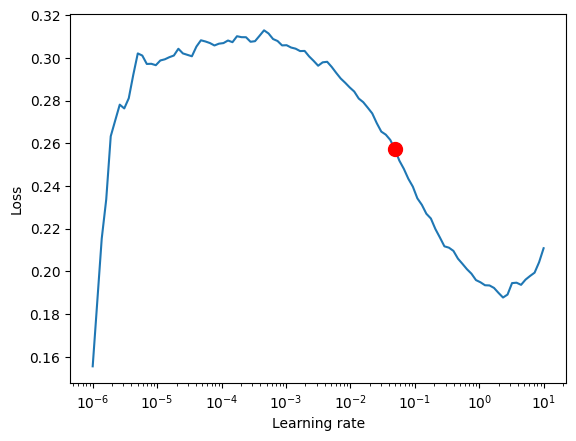

C:\Users\soere\AppData\Local\Temp\ipykernel_4760\1992069804.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [20]:
# find optimal learning rate
res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

# Train Model

In [21]:
import tensorflow as tf
import tensorboard as tb

In [22]:
# Configure the model checkpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath="./saved_models/TFT-Model/state_dict",  # Path to save the checkpoints
    filename="{epoch:02d}-{val_loss:.2f}",  # Naming convention for the saved checkpoints
    monitor="val_loss",  # Metric to monitor
    mode="min",  # Mode: min for val_loss
    save_top_k=1,  # Only keep the best model
    save_weights_only=True  # Save only the weights, not the full model
)

In [23]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=5,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

# Define specific quantiles
quantiles = [0.5, 0.917192]

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=res.suggestion(),
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(quantiles=quantiles),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\master-thesis\myenv\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\master-thesis\myenv\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Number of parameters in network: 1164.7k


In [24]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 218    | train
3  | prescalers                         | ModuleDict                      | 13.4 K | train
4  | static_variable_selection          | VariableSelectionNetwork        | 840    | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 581 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 581 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K  

c:\master-thesis\myenv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\master-thesis\myenv\lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 4: 100%|██████████| 28/28 [04:33<00:00,  0.10it/s, v_num=69, train_loss_step=0.0957, val_loss=0.119, train_loss_epoch=0.113]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 28/28 [04:40<00:00,  0.10it/s, v_num=69, train_loss_step=0.0957, val_loss=0.119, train_loss_epoch=0.113]


In [25]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

c:\master-thesis\myenv\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\master-thesis\myenv\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [26]:
# Define the path where you want to save the model after training
explicit_save_path = f"./saved_models/TFT-Model/trained_on_{percentage}/"

# Make sure directory exists
os.makedirs(explicit_save_path, exist_ok=True)

# Explicitly save the model after training
torch.save(tft.state_dict(), explicit_save_path + f"TFT-model-trained-on-{percentage}.pth")

print(f"Model explicitly saved to: {explicit_save_path}")

Model explicitly saved to: ./saved_models/TFT-Model/trained_on_1%/


# Evaluation

Validation Set

In [27]:
"""
# Set the model to evaluation mode
best_tft.eval()

# Initialize a list to store predictions
val_predictions = []

# Disable gradient computation for prediction
with torch.no_grad():
    for batch in val_dataloader:
        inputs = batch[0]  # Assuming the data is in the first element of the tuple
        
        # Get model predictions
        output = best_tft(inputs)
        
        # Extract the prediction tensor from the Output object
        prediction_tensor = output.prediction.detach().cpu().numpy()  # Detach, move to CPU, and convert to numpy
        
        # Append the numpy array of predictions
        val_predictions.append(prediction_tensor)

# Flatten the list of arrays into a single array if necessary
val_predictions = np.concatenate(val_predictions, axis=0)


for batch in val_dataloader:
    x, y = batch  # x contains the input data, y contains the target (likely a tuple)
    
    # Extract labels from y
    if isinstance(y, tuple):
        val_labels = y[0]  # y[0] contains the labels
        
        # Print the shape of the labels for each batch
        print("Labels shape:", val_labels.shape)
        
        # If needed, you can further process the labels here
        # For example, convert them to numpy:
        val_labels_numpy = labels.detach().cpu().numpy()
"""

'\n# Set the model to evaluation mode\nbest_tft.eval()\n\n# Initialize a list to store predictions\nval_predictions = []\n\n# Disable gradient computation for prediction\nwith torch.no_grad():\n    for batch in val_dataloader:\n        inputs = batch[0]  # Assuming the data is in the first element of the tuple\n        \n        # Get model predictions\n        output = best_tft(inputs)\n        \n        # Extract the prediction tensor from the Output object\n        prediction_tensor = output.prediction.detach().cpu().numpy()  # Detach, move to CPU, and convert to numpy\n        \n        # Append the numpy array of predictions\n        val_predictions.append(prediction_tensor)\n\n# Flatten the list of arrays into a single array if necessary\nval_predictions = np.concatenate(val_predictions, axis=0)\n\n\nfor batch in val_dataloader:\n    x, y = batch  # x contains the input data, y contains the target (likely a tuple)\n    \n    # Extract labels from y\n    if isinstance(y, tuple):\n

In [28]:
"""
for batch in val_dataloader:
    x, y = batch  # x contains the input data, y contains the target (likely a tuple)
    
    # Extract labels from y
    if isinstance(y, tuple):
        val_labels = y[0]  # y[0] contains the labels
        
        # Convert labels to numpy for easier manipulation
        val_labels_numpy = val_labels.detach().cpu().numpy()
        print("Labels shape:", val_labels_numpy.shape)
        
        # Check if all values in each row (timesteps) are the same
        all_same_in_timesteps = np.all(val_labels_numpy == val_labels_numpy[:, 0].reshape(-1, 1), axis=1)
        
        # Output the result
        if np.all(all_same_in_timesteps):
            print("All labels are consistent across timesteps for this batch.")
        else:
            print("Inconsistent labels found across timesteps in this batch.")
        
        # Optionally, you can print which rows are inconsistent
        inconsistent_indices = np.where(~all_same_in_timesteps)[0]
        if len(inconsistent_indices) > 0:
            print(f"Inconsistent label rows: {inconsistent_indices}")
"""

'\nfor batch in val_dataloader:\n    x, y = batch  # x contains the input data, y contains the target (likely a tuple)\n    \n    # Extract labels from y\n    if isinstance(y, tuple):\n        val_labels = y[0]  # y[0] contains the labels\n        \n        # Convert labels to numpy for easier manipulation\n        val_labels_numpy = val_labels.detach().cpu().numpy()\n        print("Labels shape:", val_labels_numpy.shape)\n        \n        # Check if all values in each row (timesteps) are the same\n        all_same_in_timesteps = np.all(val_labels_numpy == val_labels_numpy[:, 0].reshape(-1, 1), axis=1)\n        \n        # Output the result\n        if np.all(all_same_in_timesteps):\n            print("All labels are consistent across timesteps for this batch.")\n        else:\n            print("Inconsistent labels found across timesteps in this batch.")\n        \n        # Optionally, you can print which rows are inconsistent\n        inconsistent_indices = np.where(~all_same_in_ti

In [29]:
"""
# Extract the median predictions (0.5 quantile which is at index 1 along the last axis)
val_median_predictions = val_predictions[:, :, 1]

# Assuming the outputs are logits and need to be converted to probabilities
val_transformed_median_predictions = 1 / (1 + np.exp(-val_median_predictions))

# Define a threshold
threshold = 0.5 # Adjust this based on specific sensitivity or specificity needs

# Check if any time step's prediction exceeds the threshold for each instance
val_mortality_predictions = (np.any(val_transformed_median_predictions > threshold, axis=1)).astype(int)
"""

"\n# Extract the median predictions (0.5 quantile which is at index 1 along the last axis)\nval_median_predictions = val_predictions[:, :, 1]\n\n# Assuming the outputs are logits and need to be converted to probabilities\nval_transformed_median_predictions = 1 / (1 + np.exp(-val_median_predictions))\n\n# Define a threshold\nthreshold = 0.5 # Adjust this based on specific sensitivity or specificity needs\n\n# Check if any time step's prediction exceeds the threshold for each instance\nval_mortality_predictions = (np.any(val_transformed_median_predictions > threshold, axis=1)).astype(int)\n"

In [30]:
"""
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

# Flatten the labels to compare them with the mortality predictions
# Since the labels are consistent across timesteps, you can take the first value from each row
val_flat_labels = val_labels_numpy[:, 0]  # Extract the first timestep as all labels in a row are the same

# Compute Accuracy
accuracy = accuracy_score(val_flat_labels, val_mortality_predictions)
print(f"Accuracy: {accuracy:.4f}")

# Compute Precision
precision = precision_score(val_flat_labels, val_mortality_predictions)
print(f"Precision: {precision:.4f}")

# Compute Recall
recall = recall_score(val_flat_labels, val_mortality_predictions)
print(f"Recall: {recall:.4f}")

# Compute F1 Score
f1 = f1_score(val_flat_labels, val_mortality_predictions)
print(f"F1 Score: {f1:.4f}")

# Compute AUROC (Area Under the Receiver Operating Characteristic Curve)
# For AUROC, use the raw probabilities (transformed_median_predictions)
# Here, take the max predicted probability across timesteps for each sample
max_predictions = np.max(val_transformed_median_predictions, axis=1)
roc_auc = roc_auc_score(val_flat_labels, max_predictions)
print(f"AUROC: {roc_auc:.4f}")

# Compute AUPRC (Area Under the Precision-Recall Curve)
auprc = average_precision_score(val_flat_labels, max_predictions)
print(f"AUPRC: {auprc:.4f}")
"""


'\nfrom sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score\n\n# Flatten the labels to compare them with the mortality predictions\n# Since the labels are consistent across timesteps, you can take the first value from each row\nval_flat_labels = val_labels_numpy[:, 0]  # Extract the first timestep as all labels in a row are the same\n\n# Compute Accuracy\naccuracy = accuracy_score(val_flat_labels, val_mortality_predictions)\nprint(f"Accuracy: {accuracy:.4f}")\n\n# Compute Precision\nprecision = precision_score(val_flat_labels, val_mortality_predictions)\nprint(f"Precision: {precision:.4f}")\n\n# Compute Recall\nrecall = recall_score(val_flat_labels, val_mortality_predictions)\nprint(f"Recall: {recall:.4f}")\n\n# Compute F1 Score\nf1 = f1_score(val_flat_labels, val_mortality_predictions)\nprint(f"F1 Score: {f1:.4f}")\n\n# Compute AUROC (Area Under the Receiver Operating Characteristic Curve)\n# For AUROC, use the raw pro

Testing Set

In [31]:
# Set the model to evaluation mode
best_tft.eval()

# Initialize a list to store predictions
predictions = []

# Disable gradient computation for prediction
with torch.no_grad():
    for batch in test_dataloader:
        inputs = batch[0]  # Assuming the data is in the first element of the tuple
        
        # Get model predictions
        output = best_tft(inputs)
        
        # Extract the prediction tensor from the Output object
        prediction_tensor = output.prediction.detach().cpu().numpy()  # Detach, move to CPU, and convert to numpy
        
        # Append the numpy array of predictions
        predictions.append(prediction_tensor)

# Flatten the list of arrays into a single array if necessary
predictions = np.concatenate(predictions, axis=0)

In [32]:
len(predictions)

71

In [33]:
for batch in test_dataloader:
    x, y = batch  # x contains the input data, y contains the target (likely a tuple)
    
    # Extract labels from y
    if isinstance(y, tuple):
        labels = y[0]  # y[0] contains the labels
        
        # Convert labels to numpy for easier manipulation
        labels_numpy = labels.detach().cpu().numpy()
        print("Labels shape:", labels_numpy.shape)
        
        # Check if all values in each row (timesteps) are the same
        all_same_in_timesteps = np.all(labels_numpy == labels_numpy[:, 0].reshape(-1, 1), axis=1)
        
        # Output the result
        if np.all(all_same_in_timesteps):
            print("All labels are consistent across timesteps for this batch.")
        else:
            print("Inconsistent labels found across timesteps in this batch.")
        
        # Optionally, you can print which rows are inconsistent
        inconsistent_indices = np.where(~all_same_in_timesteps)[0]
        if len(inconsistent_indices) > 0:
            print(f"Inconsistent label rows: {inconsistent_indices}")

Labels shape: (71, 4)
All labels are consistent across timesteps for this batch.


In [34]:
total_samples_count = 0
for i, (x, y) in enumerate(test_dataloader):
    print(f"Batch {i+1} size: {len(x)}")
    total_samples_count += len(x)
print(f"Total samples processed: {total_samples_count}")


Batch 1 size: 11
Total samples processed: 11


In [35]:
# Flatten Labels
flat_labels = labels_numpy[:, 0]
print(len(flat_labels))

71


In [36]:
predictions.shape

(71, 4, 2)

In [37]:
Q92_predictions = predictions[:, :, 0]
median_predictions = predictions[:, :, 1]

In [38]:
transformed_median_predictions = 1 / (1 + np.exp(-median_predictions))
transformed_Q92_predictions = 1 / (1 + np.exp(-Q92_predictions))

In [39]:
transformed_Q92_predictions

array([[0.5042702 , 0.504159  , 0.5042436 , 0.5043236 ],
       [0.506895  , 0.50665545, 0.5065921 , 0.5065566 ],
       [0.5049384 , 0.50481176, 0.5048321 , 0.50490654],
       [0.50604695, 0.50583345, 0.50582165, 0.5058206 ],
       [0.5056334 , 0.5055998 , 0.5055433 , 0.50553036],
       [0.5059614 , 0.5058249 , 0.5056326 , 0.5056092 ],
       [0.5060857 , 0.50603986, 0.5060911 , 0.5061538 ],
       [0.50333124, 0.5056315 , 0.5031189 , 0.5056014 ],
       [0.50572366, 0.5055547 , 0.50551   , 0.5056479 ],
       [0.50572425, 0.5020688 , 0.5052869 , 0.50501424],
       [0.50466704, 0.50464785, 0.5045943 , 0.5046442 ],
       [0.50617737, 0.5052168 , 0.5049004 , 0.50494534],
       [0.5064699 , 0.50617087, 0.5059807 , 0.5059496 ],
       [0.5047049 , 0.50465184, 0.5045853 , 0.5047174 ],
       [0.5047725 , 0.50487465, 0.50496936, 0.5050425 ],
       [0.5039856 , 0.5041614 , 0.5043401 , 0.5045966 ],
       [0.50513464, 0.50499564, 0.5049897 , 0.5050359 ],
       [0.5052379 , 0.50491834,

In [40]:
# Call the evaluation function on Q1 Predictions
evaluate_tft_predictions(
    flat_labels=flat_labels,  # The true labels (first timestep of each sequence)
    transformed_predictions=transformed_median_predictions,  # The raw probabilities across timesteps
    directory=f"./saved_models/TFT-Model/trained_on_{percentage}/transformed_median_predictions",  # Directory to save metrics and plots
    model_name=f"TFT Model - Trained on {percentage}"  # Name of the model for display and saving
)

Best Threshold based on F2 score: 0.5761
Accuracy: 0.8028
Precision: 0.2500
Recall: 0.6667
F1 Score: 0.3636
AUROC: 0.7667
AUPRC: 0.2531
Performance metrics saved to: ./saved_models/TFT-Model/trained_on_1%/transformed_median_predictions/TFT Model - Trained on 1%_metrics.txt


C:\Users\soere\AppData\Local\Temp\ipykernel_4760\938378855.py:20: RuntimeWarning: invalid value encountered in divide
  f_beta_scores = (1 + beta**2) * (precision_vals * recall_vals) / ((beta**2 * precision_vals) + recall_vals)


In [41]:
# Call the evaluation function on Q1 Predictions
evaluate_tft_predictions(
    flat_labels=flat_labels,  # The true labels (first timestep of each sequence)
    transformed_predictions=transformed_Q92_predictions,  # The raw probabilities across timesteps
    directory=f"./saved_models/TFT-Model/trained_on_{percentage}/transformed_Q92_predictions",  # Directory to save metrics and plots
    model_name=f"TFT Model - Trained on {percentage}"  # Name of the model for display and saving
)

Best Threshold based on F2 score: 0.5062
Accuracy: 0.8732
Precision: 0.2857
Recall: 0.3333
F1 Score: 0.3077
AUROC: 0.5949
AUPRC: 0.3321
Performance metrics saved to: ./saved_models/TFT-Model/trained_on_1%/transformed_Q92_predictions/TFT Model - Trained on 1%_metrics.txt


# Interpret Model

In [42]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

# Extract dict with interpretations
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")

# Plot the predictions
interpretation_figures = best_tft.plot_interpretation(interpretation)

for plot_name, fig in interpretation_figures.items():
    # Specify the directory path where you want to save the figures
    directory_path = f'./saved_models/TFT-Model/trained_on_{percentage}'
    # Create the directory if it doesn't exist
    os.makedirs(directory_path, exist_ok=True)
    
    # Construct file path dynamically based on plot name
    file_path = f'{directory_path}/{plot_name}_interpretation.png'
    # Save the figure
    fig.savefig(file_path)
    print(f"Saved {plot_name} plot to {file_path}")

    # Close the figure after saving to free up memory
    plt.close(fig)

c:\master-thesis\myenv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Saved attention plot to ./saved_models/TFT-Model/trained_on_1%/attention_interpretation.png
Saved static_variables plot to ./saved_models/TFT-Model/trained_on_1%/static_variables_interpretation.png
Saved encoder_variables plot to ./saved_models/TFT-Model/trained_on_1%/encoder_variables_interpretation.png
Saved decoder_variables plot to ./saved_models/TFT-Model/trained_on_1%/decoder_variables_interpretation.png


# Partial Dependency

In [43]:
dependency = best_tft.predict_dependency(
    val_dataloader.dataset, "CHART_227628", np.linspace(0, 30, 30), show_progress_bar=True, mode="dataframe"
)

Predict:   0%|          | 0/30 [00:00<?, ? batches/s]c:\master-thesis\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\master-thesis\myenv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
Predict:   3%|▎         | 1/30 [00:04<02:13,  4.61s/ batches]c:\master-thesis\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\master-thesis\myenv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_wor

Predict: 100%|██████████| 30/30 [01:54<00:00,  3.81s/ batches]


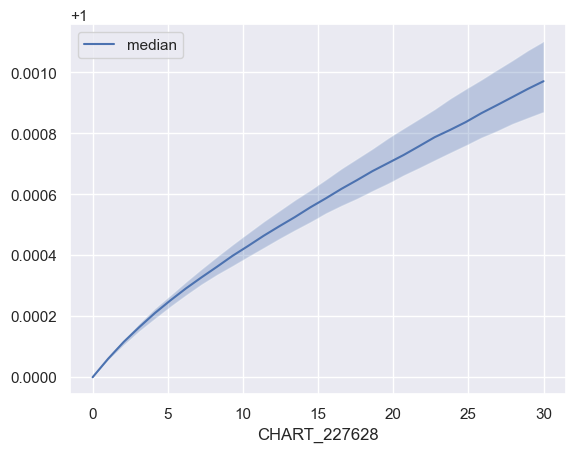

In [44]:
# plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby("CHART_227628").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3)